## Чистка и подготовка данных (21.02.16)

Здесь было много обзора данных. Оставил только то, что нужно дальше.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
%matplotlib inline

from numpy.fft import fft, rfft, rfftfreq, irfft
import seaborn as sns
from scipy.optimize import differential_evolution

In [2]:
data = open("00000016.txt", 'r').readlines()
splitted = [s.split() for s in data]
data2 = pd.DataFrame(splitted, columns=['sig1', 'sig2']).astype(float)
print data2.shape
#data2.head(2)

FD = 2000 # 2кГц - частота дискретизации сигнала

(1811164, 2)


## Обзор датасета

### Второй датасет - два сигнала 

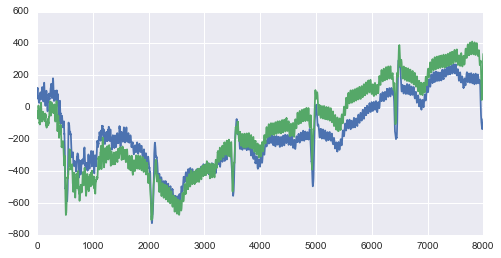

In [3]:
lim = 8000
part = data2[:lim]
plt.figure(figsize=(8,4))
plt.plot(part.sig1)
plt.plot(part.sig2)

# FFT преобразования сигналов (22-23.06.16)

В спектре явно доминирует диапазон 1-3 Hz, четко виден сигнал на ~50Hz от розетки

In [4]:
# функция для перевода герцевого диапазона в числовой. Делает то же самое, что rfftfreq, но для двух точек.
def hz(N, d, a, b):
    return int((N)*float(a)/(d)), int((N)*float(b)/(d))

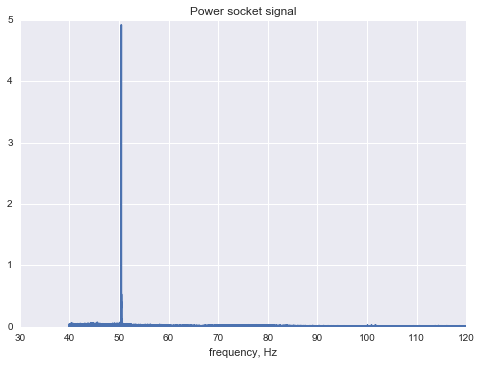

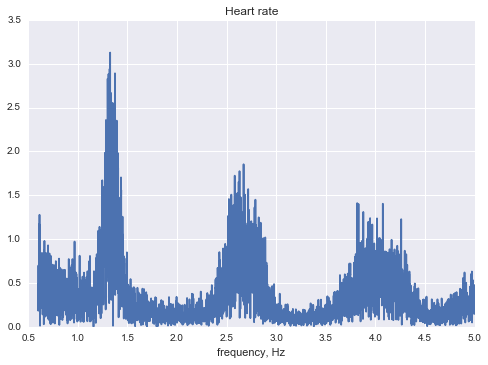

In [361]:
from numpy.fft import rfft, rfftfreq

FD = 2000 # частота дискретизации сигнала
N = len(data2.sig1)
l, r = hz(N, FD, a=40, b=120) # интересующий нас промежуток частот
spectre = rfft(data2.sig1)
plt.plot(rfftfreq(N, 1./FD)[l:r], (np.abs(spectre)/N)[l:r])
plt.title("Power socket signal")
plt.xlabel("frequency, Hz")
plt.figure()
l, r = hz(N, FD, 0.6, 5)
plt.plot(rfftfreq(N, 1./FD)[l:r], (np.abs(spectre)/N)[l:r])
plt.title("Heart rate")
plt.xlabel("frequency, Hz")
#plt.plot(range(len(spectrum))[l,r], (np.abs(spectrum)/N)[l,r])

На первом графике четко видна розетка (~50Hz), на втором - два самых доминирующих пика в спектре. Первый - ~1.6HZ - вероятно, сердце (но все равно как-то быстро). Что есть второй пик - ~3Hz - пока не понял. //Вопрос Виктору. 

## Обратное FFT-преобразование, чистка затиранием частот. (середина марта, эксперимент с затираниями)

In [384]:
from numpy.fft import irfft
errors4 = []
file_names = [str(num) + ".txt" for num in range(1, 11)]

for file_name in file_names:
    print(file_name)
    data2 = open(file_name, 'r').readlines()
    splitted = [s.split() for s in data2]
    if (len(splitted) % 2 == 1): splitted = splitted[:-1]
    data2 = pd.DataFrame(splitted, columns=['sig1', 'sig2']).astype(float)
    
    spectre = rfft(data2.sig1)
    
    mn, mx = getExtremaSuperFast(data2.sig1)
    _, lits, _ = analyzeLiterals(data2.sig1, mn, mx)

    test_spec = spectre.copy()
    test_spec2 = spectre.copy()
    l,r = hz(len(test_spec), FD, a=0.5, b=150)
    test_spec[:l] = 0
    t = irfft(test_spec)[:len(data2.sig1)]
    print len(t), len(data2.sig1)
    data2["cleaned_l"] = t
    _, lits2, _ = analyzeLiterals(data2.cleaned_l, mn, mx)
    test_spec2[r:] = 0
    data2["cleaned_r"] = irfft(test_spec2[:len(data2.sig1)])
    _, lits3, _ = analyzeLiterals(data2.cleaned_r, mn, mx)
    
    errors4.append((compareLits(lits, lits2), compareLits(lits, lits3))) 

1.txt
781728 781728
2.txt
897020 897020
3.txt
956946 956946
4.txt
958820 958820
5.txt
769456 769456
6.txt
1811164 1811164
7.txt
949756 949756
8.txt
741410 741410
9.txt
828670 828670
10.txt
840840 840840


In [386]:
errs1 = []
errs2 = []
for (err1, err2) in errors4:
    errs1.append(err1)
    errs2.append(err2)
    
print np.mean(errs1), np.mean(errs2)

0.0318375138515 0.217621463349


## Short Time Fourier Transform (25.02.16, 1.03.2016)

После разговора со старшим товарищем выяснилось, что чистить весь сигнал сразу - не лучшая идея: частота основного шума "плывет" с течением времени, и 50Гц при одновременном разложении всего сигнала - это только усредненная частота. Необходимо чистить локально, на каждом промежутке между двумя пиками. Для этого есть алгоритм STFT. Подробнее:
https://kevinsprojects.wordpress.com/2014/12/13/short-time-fourier-transform-using-python-and-numpy/

### Несколько подготовительных соображений

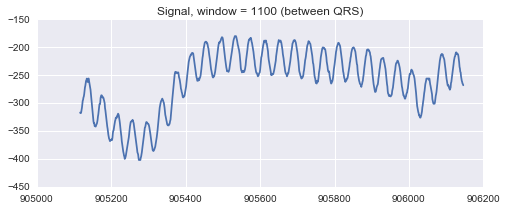

In [6]:
fft_size = 1031
signal = data2.sig1
border = (len(signal) - fft_size)/2+50 #взяли промежуток где-нибудь в центре сигнала
segment = data2.sig1[border: border+fft_size]
plt.figure(figsize=(8,3))
plt.plot(segment)
plt.title("Signal, window = 1100 (between QRS)")

Frequency of the peak is  50.44 Hz, amplitude is -16.54


C:\Users\aksho\Anaconda2\lib\site-packages\numpy\core\numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\aksho\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


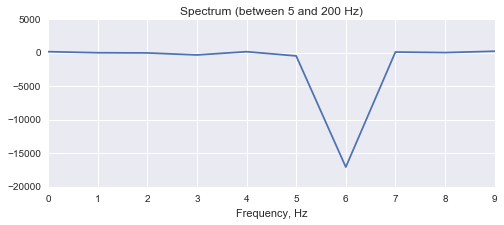

In [9]:
spectrum = rfft(segment)
x_axis = rfftfreq(fft_size, 1./FD)
a,b = hz(fft_size, FD, 40, 60)
plt.figure(figsize=(8,3))
plt.plot(spectrum[a:b])
plt.title("Spectrum (between 5 and 200 Hz)")
plt.xlabel("Frequency, Hz")
w = np.argmin(spectrum[a:b]) #частота розетки
A = spectrum[a+w]/fft_size #амплитутда
print "Frequency of the peak is ", round(x_axis[a:b][w], 2), "Hz, amplitude is", round(A, 2)

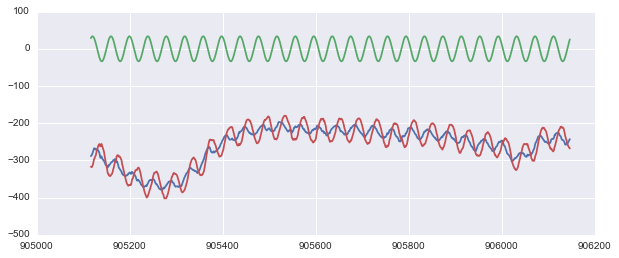

In [10]:
#Функиця, которую мы будем отнимать от промежутка

def cos_to_remove(x):
    return (2.)*A*np.exp(2*1j*np.pi*(a+w)*(x-fft_size/2)/fft_size)

x_axis = range(border, border+fft_size)
cos_graph = [cos_to_remove(x) for x in x_axis]
plt.figure(figsize=(10, 4))
plt.plot(x_axis, segment+cos_graph)
plt.plot(x_axis, cos_graph)
plt.plot(x_axis, segment)

Поддалось^^. Но тройка - ручная колибровка. Нужно понять как это автоматизировать

## Склейка чищенных диапазонов по пикам

Одно из заданий Виктора: взять минимального размера окно, итеративно продлевать его с обоих сторон на 128 точек, раскладывать в спектр и смотреть как меняется положение пика в районе 40-60 Hz (розетка):

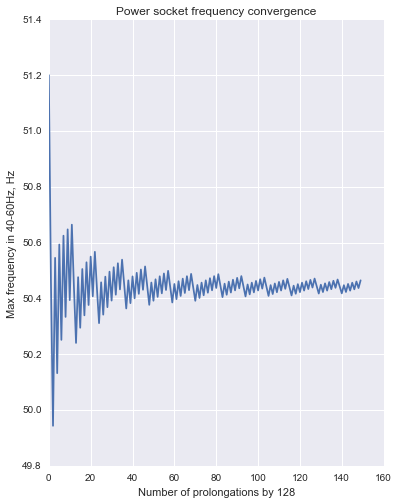

In [11]:
signal = data2.sig1
prolong = 128 # число точек, на которые удлиняется промежуток каждый шаг
steps = 150 #число удлинений промежутка влево и вправо на prolong
start_size = 1250 # первоначальный размер окна
start_point = (len(signal) - start_size)/2 #точка в середине сигнала, от которой начинается процесс
result = []
for i in range(steps):
    segment = signal[start_point-i*prolong : start_point+start_size+i*prolong]
    windowed = segment*np.hanning(len(segment))
    #padded = np.append(windowed, np.zeros(len(windowed)))
    spectrum = rfft(windowed)/len(segment)
    autopower = np.abs(spectrum*np.conj(spectrum))
    a,b = hz(N=len(windowed), d=FD, a=40, b=60)
    x_axis = rfftfreq(len(windowed), 1./FD)[a:b]
    m = x_axis[sp.argmax(autopower[a:b])]
    result.append(m)

plt.figure(figsize=(6,8))    
plt.plot(result)
plt.title("Power socket frequency convergence")
plt.ylabel("Max frequency in 40-60Hz, Hz")
plt.xlabel("Number of prolongations by 128")

## Построение функции автокорреляции и нахождение координат "пиков". (26-27.02.16)

Первая идея - прогонять эталонный qrs вдоль сигнала и искать скачки их свертки

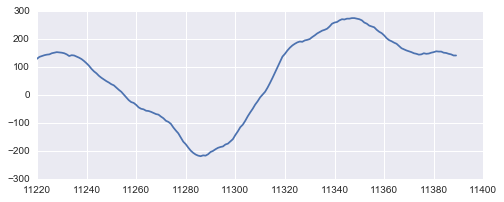

In [7]:
fft_size = 170
signal = data2.sig1
border = 11220 #взяли промежуток где-нибудь в центре сигнала
segment = data2.sig1[border: border+fft_size].copy()
plt.figure(figsize=(8,3))
plt.plot(segment)

66


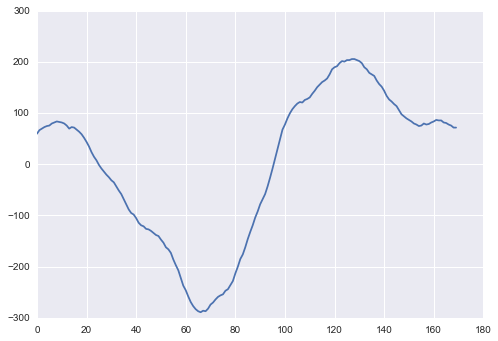

In [8]:
from sklearn.preprocessing import scale
scaled = scale(segment, with_std=False)
plt.plot(scaled)
ideal_max = np.argmax(scaled)
ideal_min = np.argmin(scaled)
print ideal_min

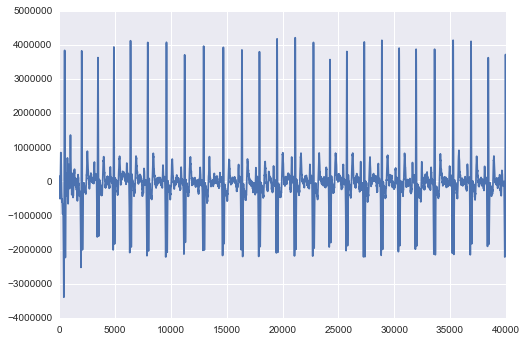

In [9]:
signal = data2.sig1
lim = 40000
win_len = 170
corr = []
for i in range(0, lim):
    win = signal[i:i+win_len]
    corr.append(np.correlate(scaled, scale(win, with_std = False)))
plt.plot(corr)

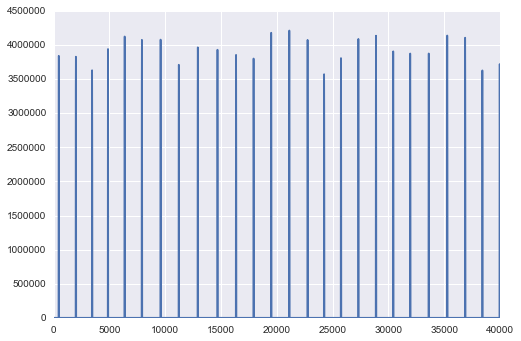

In [10]:
m = np.max(corr)
peaks = np.array([x if x > m/2 else 0 for x in corr]);
plt.plot(peaks)

In [11]:
from scipy.signal import argrelextrema
max_peak_points = argrelextrema(peaks, np.greater) + ideal_max
min_peak_points = argrelextrema(peaks, np.greater) + ideal_min
print max_peak_points
print min_peak_points

[[  592  2124  3579  5004  6496  8041  9716 11347 13049 14814 16478 18048
  19629 21253 22887 24368 25880 27440 29018 30564 32086 33742 35404 37007
  38550 40101]]
[[  531  2063  3518  4943  6435  7980  9655 11286 12988 14753 16417 17987
  19568 21192 22826 24307 25819 27379 28957 30503 32025 33681 35343 36946
  38489 40040]]


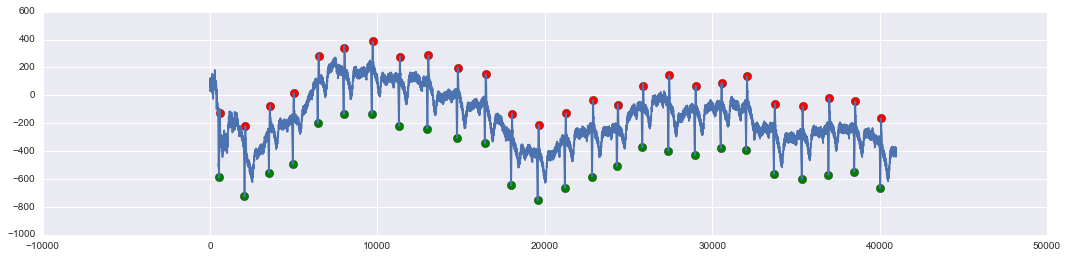

In [12]:
s = signal[:lim+1000]
#print(s)
epsilon=10
real_max_peak_points = [np.argmax(s[x-epsilon : x+epsilon]) for x in max_peak_points[0]]
real_min_peak_points = [np.argmin(s[x-epsilon : x+epsilon]) for x in min_peak_points[0]]

plt.figure(figsize=(18,4))
plt.plot(s)
#plt.scatter(peaks_points, [s[x] for x in peaks_points], c='r', s=70)
plt.scatter(real_max_peak_points, [s[x] for x in real_max_peak_points], c='r', s=70)
plt.scatter(real_min_peak_points, [s[x] for x in real_min_peak_points], c='g', s=70)

Работает ^^

## Кодирование сигнала: конвертация дельт размаха и периода промежутков в литеры (28.02.16)

Посчитаем периоды, амплитуды, углы и их дельты

In [13]:
periods = []
delta_periods = []
amplitudes = [s[real_max_peak_points[0]] - s[real_min_peak_points[0]]]
delta_amplitudes = []
angles = []
delta_angles = []
for i in range(len(real_max_peak_points)-1):
    periods.append(real_max_peak_points[i+1]-real_max_peak_points[i])
    amplitudes.append(s[real_max_peak_points[i+1]] - s[real_min_peak_points[i+1]])
    angles.append(float(amplitudes[i])/periods[i])
    if (i >= 1):
        delta_periods.append((periods[i] - periods[i-1])>=0)
        delta_amplitudes.append((amplitudes[i]-amplitudes[i-1])>=0)
        delta_angles.append((angles[i]-angles[i-1])>=0)

In [14]:
deltas = zip(delta_amplitudes, delta_periods, delta_angles)

liters_dict = {
    (True, True, True) : "A",
    (False, False, True) : "B",
    (True, False, True) : "C",
    (False, True, False) : "D",
    (True, True, False) : "E",
    (False, False, False) : "F"
}

literals = [liters_dict[c] for c in deltas]
print literals

['C', 'F', 'A', 'D', 'D', 'C', 'D', 'A', 'B', 'B', 'A', 'A', 'D', 'C', 'D', 'E', 'A', 'F', 'F', 'A', 'D', 'C', 'C', 'D']


In [15]:
from collections import Counter
codograms = Counter()
for i in range(len(literals)-3):
    win = literals[i:i+3]
    code = ''.join(win)
    codograms[code] += 1
codograms

Counter({'AAD': 1,
         'ABB': 1,
         'ADC': 2,
         'ADD': 1,
         'AFF': 1,
         'BAA': 1,
         'BBA': 1,
         'CDA': 1,
         'CDE': 1,
         'CFA': 1,
         'DAB': 1,
         'DCC': 1,
         'DCD': 2,
         'DDC': 1,
         'DEA': 1,
         'EAF': 1,
         'FAD': 2,
         'FFA': 1})

## Реализация итогов исследования в виде функции (1.03.2016-4.03.2016)

In [273]:
def getExtrema(signal, model, peak_criterion=0.7, epsilon=10):
    from sklearn.preprocessing import scale
    import numpy as np
    
    scaled = scale(model, with_std=False)
    ideal_max = np.argmax(scaled)
    ideal_min = np.argmin(scaled)
    
    win_len = len(model)
    corr = []
    for i in range(0, len(signal) - win_len):
        win = signal[i:i+win_len]
        corr.append(np.correlate(scaled, scale(win, with_std = False)))

    m = max(corr)
    peaks = np.array([x if x > m*peak_criterion else 0 for x in corr]);
    
    from scipy.signal import argrelextrema
    max_peak_points = argrelextrema(peaks, np.greater) + ideal_max
    min_peak_points = argrelextrema(peaks, np.greater) + ideal_min
    
    real_max_peak_points = [np.argmax(signal[x-epsilon : x+epsilon]) - signal.index[0] for x in max_peak_points[0]]
    real_min_peak_points = [np.argmin(signal[x-epsilon : x+epsilon]) - signal.index[0] for x in min_peak_points[0]]
    
    return real_min_peak_points, real_max_peak_points

def analyzeLiterals(s, mn, mx):
    periods = []
    delta_periods = []
    amplitudes = []#[s[mx[0]] - s[mn[0]]]
    delta_amplitudes = []
    angles = []
    delta_angles = []
    abs_deltas = []
    for i in range(len(mx)-1):
        p = mx[i+1]-mx[i]
        periods.append(np.abs(p))
        am = np.abs(s[mx[i]] - s[mn[i]])
        amplitudes.append(am)
        angles.append(float(am)/p)
        if (i >= 1):
            delta_periods.append((periods[i] - periods[i-1])>=0)
            delta_amplitudes.append((amplitudes[i]-amplitudes[i-1])>=0)
            abs_deltas.append(np.abs(amplitudes[i]-amplitudes[i-1]))
            delta_angles.append((angles[i]-angles[i-1])>=0)
    deltas = zip(delta_amplitudes, delta_periods, delta_angles)
    
    for i in range(len(deltas)):
        if ((deltas[i] == (True, False, False)) | (deltas[i]==(False, True, True))):
            print deltas[i]
            print amplitudes[i-1], amplitudes[i]
            print periods[i-1], periods[i]
            print angles[i-1], angles[i]
    
    liters_dict = {
        (True, True, True) : "A",
        (False, False, True) : "B",
        (True, False, True) : "C",
        (False, True, False) : "D",
        (True, True, False) : "E",
        (False, False, False) : "F",
        (True, False, False) : "X"
    }

    literals = [liters_dict[c] for c in deltas]
    
    from collections import Counter
    codograms = Counter()
    for i in range(len(literals)-3):
        win = literals[i:i+3]
        code = ''.join(win)
        codograms[code] += 1
    return codograms, literals, abs_deltas

def getMids(points):
    prev= points[0]
    mids = []
    for i in points[1:]:
        center = (i + prev)/2
        mids.append(center)
        prev = i
    return mids

def deSocket(sig, fd, interval=(40, 60)):
    from numpy.fft import rfft, rfftfreq
    
    #mn, mx = getExtrema(sig, model)
    
    spectrum = rfft(sig)
    x_axis = rfftfreq(len(sig), 1./fd)
    a,b = hz(len(sig), fd, interval[0], interval[1])
    w = np.argmax(np.abs(spectrum[a:b])) #частота 
    A = spectrum[a+w]/len(sig) #амплитутда
    
    def cos_to_remove(x):
        return (2.)*A*np.exp(2*1j*np.pi*(a+w)*(x-len(sig)/2)/len(sig))

    cos_graph = [cos_to_remove(x) for x in range(len(sig))]
    return cos_graph + sig


def deSocketFull(sig, fd, interval=(40, 60), delta=517, border=50):
    from numpy.fft import rfft, rfftfreq
    
    clr_sig = sig.copy()
    
    mn, mx = getExtrema(clr_sig, segment)
    mids1 = getMids(mx)
    mx1 = sorted(np.concatenate([mids1, mx]))
    mids = getMids(mx1)
    for i in range(len(mids)):
        sig_part = clr_sig[mids[i]-delta/2 : mids[i]+delta/2]
        spectrum = rfft(sig_part)
        x_axis = rfftfreq(len(sig_part), 1./fd)
        a,b = hz(len(sig_part), fd, interval[0], interval[1])
        w = np.argmax(np.abs(spectrum[a:b])) #частота 
        A = spectrum[a+w]/len(sig_part) #амплитутда

        def cos_to_remove(x):
            return (2.)*A*np.exp(2*1j*np.pi*(a+w)*(x)/len(sig_part))

        left = mids[i]-delta/2-200
        right = mids[i]+delta/2+200
        #cos_graph = [cos_to_remove(x) for x in range(len(sig[mx[i]:mx[i+1]]) + 2*border)]
        cos_graph = [cos_to_remove(x) for x in range(-(right-left)/2, (right-left)/2)]
        
        graph_len = len(cos_graph) -1
        
        scale = border
        for j in range(scale):
            cos_graph[j] *= float(j)/(scale)
            cos_graph[graph_len-j] *= float(j)/(scale)
        
        clr_sig[left:right] += np.real(cos_graph)
        start_index = clr_sig.index[0]
    return clr_sig, mn + start_index, mx + start_index

In [19]:
s = signal[70000:90000]

fig, mn, mx = deSocketFull(s, 2000)
a, _, _ = analyzeLiterals(s, mn, mx)
b, _, _ = analyzeLiterals(fig, mn, mx)
a.subtract(b)
print float(sum(np.abs(a.values()))/2)/len(b.values())

0.714285714286


Работает долго. Надо ускорять. Оставим этот вариант как первое, наихудшее, приближение.

### Note: 4-6 марта подходил к концу Changellenge Cup Techincal 2016 (чемпионат по решению бизнес-кейсов), на что-либо еще времени не хватало

## Экспериментальные версии алгоритма вычищения розетки (поиск способа ускорить работу) (7.03.2016)

1) Автокорреляция считается очень долго. Необходимо увеличить шаг.
    1. Найти баланс между длиной шага и качеством обнаружения пиков

In [108]:
import threading as thr

def testCorr(signal, model):
    corr = []
    win_len = len(model)
    scaled = scale(model, with_std=False)
    prev = 0
    for i in range(0, len(signal) - win_len, 2):
        win = signal[i:i+win_len]
        current_step = np.correlate(scaled, scale(win, with_std = False))
        corr.append((prev+current_step)/2)
        corr.append(current_step)
        prev = current_step
    #m = max(corr)
    return corr

def testParCorr(signal, model, n):
    part_len = len(signal)/n
    threads = []
    for i in range(n-1):
        t = thr.Thread(target=testCorr, args=(signal[i*part_len:(i+1)*part_len], model))
        t.start()
        threads.append(t)
    t = thr.Thread(target=testCorr, args=(signal[(n-1)*part_len:], model))
    t.start()
    threads.append(t)
    for t in threads:
        t.join()
    
%timeit -n 3 testCorr(signal[70000:90000], segment)
#plt.plot(testCorr(signal[70000:77000], segment))

3 loops, best of 3: 8.7 s per loop


2) Может не стоит синтезировать синусоиду и вычитать ее, а достаточно просто занизить все компоненты розетки в спектре и сделать обратное преобразование?
    1. Выяснить, на сколько падает качество при таком топорном подходе

## Анализ устойчивости метода диагностики (8.03.2016)

Постановка задачи:
Выяснить насколько сильно меняется частота литеров в сигнале после его чистки. Проанализировать для разных сдвигов, отклонений, амплитуд и тд

In [118]:
def noiseSin(x, a, ampl, shift):
    return ampl*np.exp(2*1j*np.pi*(a)*(x-shift)/512)

def compareLits(a, b):
    counter = 0
    for i in range(len(a)):
        if (a[i] != b[i]):
            counter+=1
    return float(counter)/len(a)

In [176]:
data2 = open("00000016.txt", 'r').readlines()
splitted = [s.split() for s in data2]
data2 = pd.DataFrame(splitted, columns=['sig1', 'sig2']).astype(float)
#s = data2.sig1[70000:230000]
#fig, mn, mx = deSocketFull(s, 2000)

In [82]:
def fixPeaks(s, mn, mx):
    real_max_peak_points = [np.argmax(s[x-epsilon : x+epsilon]) - s.index[0] for x in mx]
    real_min_peak_points = [np.argmin(s[x-epsilon : x+epsilon]) - s.index[0] for x in mn]
    return real_min_peak_points, real_max_peak_points

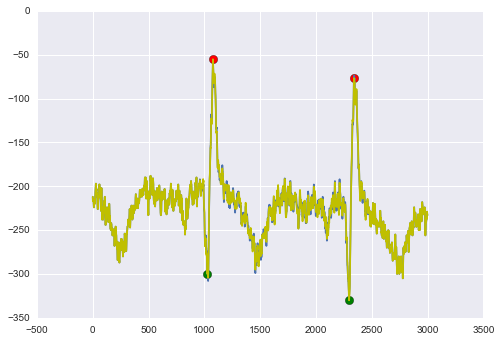

In [125]:
s = data2.sig1[70000:73000]
fig2, _ ,_ = deSocketFull(s, 2000)


mn, mx = getExtrema(fig2, segment)

fig2 = fig2.values

plt.plot(s.values)
plt.plot(fig2, c="y")
plt.scatter(mx, [fig2[x] for x in mx], c='r', s=70)
plt.scatter(mn, [fig2[x] for x in mn], c='g', s=70)

# rmn, rmx = fixPeaks(fig2, mn, mx)
# plt.scatter(mx, [fig2[x] for x in rmx], c='r', s=70)
# plt.scatter(mn, [fig2[x] for x in rmn], c='g', s=70)

In [70]:
plt.figure(figsize=(30, 6))
_, lit, _ = analyzeLiterals(fig, mn, mx)
print len(lit), len(mx)

109 111


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


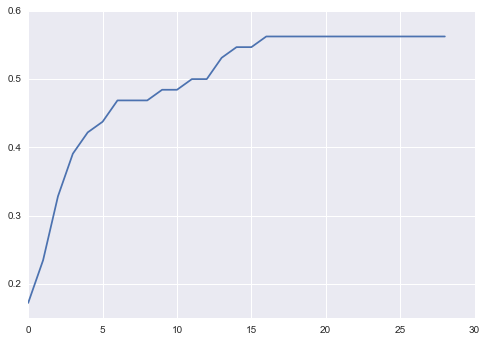

In [200]:
ampl =np.mean([s[mx[i]] - s[mn[i]] for i in range(len(mn))])
shift = 10000
a,b = hz(512, 2000, 50.45, 60)

# plt.plot(fig[shift:shift+512].values)
# plt.plot([noiseSin(x, a, shift=1) for x in range(512)])

# noise = [noiseSin(x, a, shift=1) for x in range(len(s))]
# res = fig - np.real(noise)

# plt.plot(res[shift:shift+512].values)
# _, lit_new = analyzeLiterals(res, mn, mx)
# print lit
# print lit_new
# print compareLits(lit, lit_new)
errors = []
for alpha in np.linspace(0, 0.5, 50):    
    for shift in range(0, 20, 5):
        loc_errors = []
        noise = [noiseSin(x, a, alpha, shift) for x in range(len(fig))]
        res = fig - np.real(noise)
        _, lit_new = analyzeLiterals(res, mn, mx)
        loc_errors.append(compareLits(lit, lit_new))
    errors.append(np.mean(loc_errors))
    print(alpha)

In [44]:
plt.plot(errors)

NameError: name 'errors' is not defined

Визуализируем полученные данные

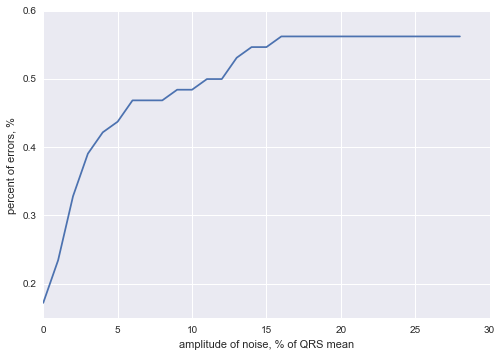

In [202]:
plt.plot(errors)
plt.xlabel("amplitude of noise, % of QRS mean")
plt.ylabel("percent of errors, %")

Получилось много. Но результаты объяснимы: литеры формируются (в том числе) из разности высот между пиками, а не от абсолютных значений.

## Анализ устойчивости к ошибкам при шуме вблизи средней дельты между пиками

In [127]:
mn, mx = getExtrema(fig, segment)

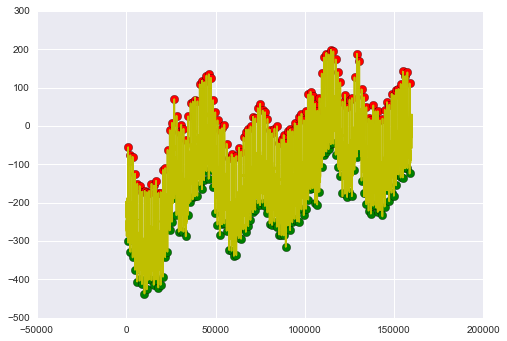

In [128]:
plt.plot(fig.values, c="y")
plt.scatter(mx, [fig.values[x] for x in mx], c='r', s=70)
plt.scatter(mn, [fig.values[x] for x in mn], c='g', s=70)

In [129]:
from IPython.html.widgets import FloatProgress
from IPython.display import display

_, lit, deltas = analyzeLiterals(fig.values, mn, mx)

ampl = np.mean(deltas)
print(ampl)

a,b = hz(512, 2000, 50.45, 60)

steps = 50

f = FloatProgress(min=0, max=steps)
display(f)

i=1
errors2 = []
for alpha in np.linspace(0, ampl, steps):    
    for shift in range(0, 60, 15):
        loc_errors = []
        noise = [noiseSin(x, a, alpha, shift) for x in range(len(fig))]
        res = fig - np.real(noise)
#         plt.figure()
#         plt.plot(res[:lim].values, c="g")
#         plt.plot(np.real(noise)[:lim], c="b")
#         plt.plot(fig[:lim].values, c="r")
        _, lit_new, _ = analyzeLiterals(res.values, mn, mx)
        loc_errors.append(compareLits(lit, lit_new))
    errors2.append(np.mean(loc_errors))
    #print(alpha)
    f.value = i
    i+=1

13.591325841


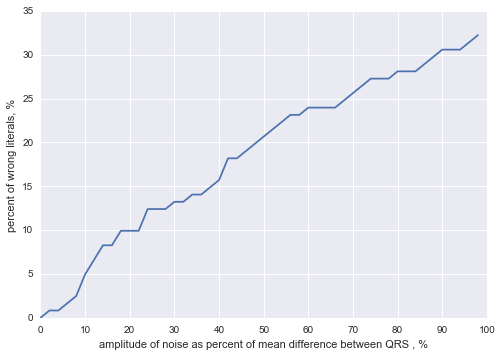

In [130]:
plt.plot(np.array(errors2)*100)
xticks_num = 11
plt.xticks(range(0, xticks_num*5, 5), [int(x) for x in np.linspace(0, ampl, xticks_num)/np.mean(deltas)*100])
plt.xlabel("amplitude of noise as percent of mean difference between QRS , %")
#plt.yticks(range(len(errors2)), errors2*100)
plt.ylabel("percent of wrong literals, %")

## Гиперускоренные версии поиска пиков (13.03.2016)

In [225]:
from sklearn.preprocessing import scale

def getExtremaSuperFast(signal2, scan_area = 700, sdf_area = 6000, abs_indexes=False):
    mn, mx = getExtrema(signal2[:sdf_area], segment)
    
    signal = signal2.values
    
    delta_max = []
    for i in range(1, len(mx)):
        delta_max.append(mx[i] - mx[i-1])
    
    delta_min = []
    for i in range(1, len(mn)):
        delta_min.append(mn[i] - mn[i-1])
        
    mean_delta_max = int(np.mean(delta_max))
    mean_delta_min = int(np.mean(delta_min))
    
    max_center =  mx[-1] + mean_delta_max
    min_center =  mn[-1] + mean_delta_min
    while ((max_center < len(signal)) & (min_center < len(signal))):
        current_max = max_center - scan_area/2 + np.argmax(scale(signal[max_center - scan_area/2 : max_center + scan_area/2], with_std = False))
        current_min = min_center - scan_area/2 + np.argmin(scale(signal[min_center - scan_area/2 : min_center + scan_area/2], with_std = False))
        delta_max = delta_max[1:]
        delta_max.append(current_max - mx[-1])
        delta_min = delta_min[1:]
        delta_min.append(current_min - mn[-1])
        #mean_delta_max = int(np.mean([mean_delta_max, current_max - mx[-1]]))
        #mean_delta_min = int(np.mean([mean_delta_min, current_min - mn[-1]]))
        mx.append(current_max)
        mn.append(current_min)
        max_center = current_max + int(np.mean(delta_max))
        min_center = current_min + int(np.mean(delta_min))
        #max_center =  current_max + mean_delta_max
        #min_center =  current_min + mean_delta_min
    
    
    mx = [i + signal2.index[0] for i in mx]
    mn = [i + signal2.index[0] for i in mn]
    return mn, mx
    

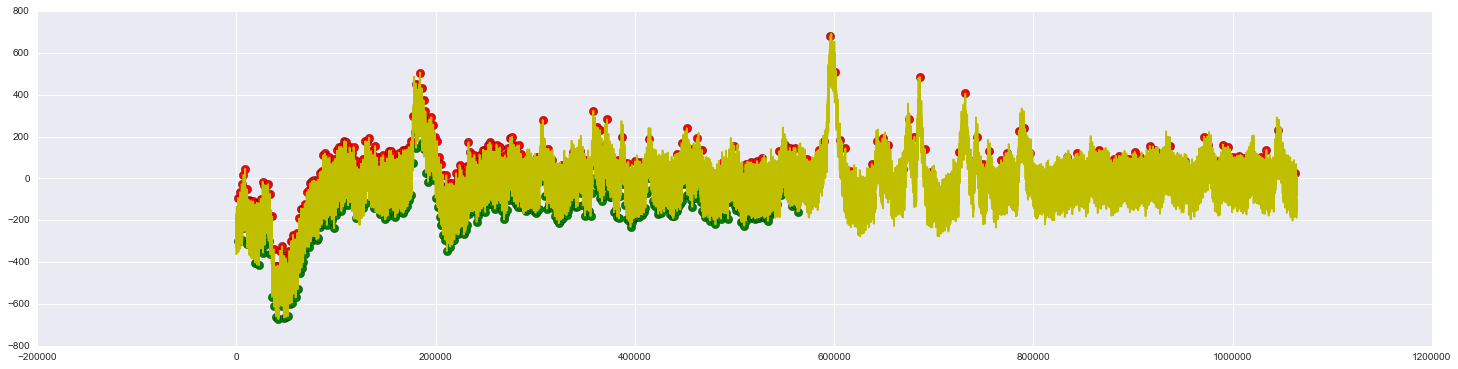

In [301]:
file_name = "00000030.txt"
data = open(file_name, 'r').readlines()
splitted = [s.split() for s in data]
data = pd.DataFrame(splitted, columns=['sig1', 'sig2']).astype(float)
fig = data.sig1
    
mn, mx = getExtremaSuperFast(fig, sdf_area=5000)
#fig = deSocketFullFast(fig, 2000)
#mn, mx = getExtremaSuperFast(fig, sdf_area=5000)
plt.figure(figsize=(25, 6))
plt.plot(fig, c="y")
plt.scatter(mx, [fig[x] for x in mx], c='r', s=70)
plt.scatter(mn, [fig[x] for x in mn], c='g', s=70)

In [261]:
def deSocketFullFast(sig, fd, interval=(40, 60), delta=517, border=50):
    from numpy.fft import rfft, rfftfreq
    
    clr_sig = sig.copy()
    
    mn, mx = getExtremaSuperFast(clr_sig)
    mids1 = getMids(mx)
    mx1 = sorted(np.concatenate([mids1, mx]))
    mids = getMids(mx1)
    for i in range(len(mids)):
        sig_part = clr_sig[mids[i]-delta/2 : mids[i]+delta/2]
        spectrum = rfft(sig_part)
        a,b = hz(len(sig_part), fd, interval[0], interval[1])
        w = np.argmax(np.abs(spectrum[a:b])) #частота 
        A = spectrum[a+w]/len(sig_part) #амплитутда

        def cos_to_remove(x):
            return (2.)*A*np.exp(2*1j*np.pi*(a+w)*(x)/len(sig_part))

        left = mids[i]-delta/2-200
        right = mids[i]+delta/2+200
        #cos_graph = [cos_to_remove(x) for x in range(len(sig[mx[i]:mx[i+1]]) + 2*border)]
        cos_graph = [cos_to_remove(x) for x in range(-(right-left)/2, (right-left)/2)]
        
        graph_len = len(cos_graph) -1
        
        scale = border
        for j in range(scale):
            cos_graph[j] *= float(j)/(scale)
            cos_graph[graph_len-j] *= float(j)/(scale)
        
        clr_sig[left:right] += np.real(cos_graph)
    return clr_sig

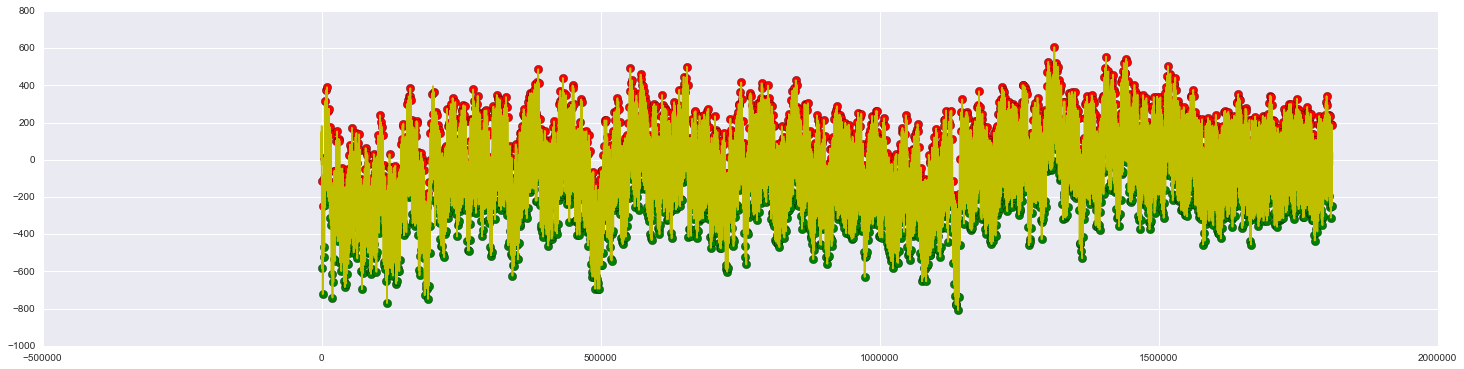

In [237]:
fig, mn, mx = deSocketFullFast(data2.sig1, 2000)
plt.figure(figsize=(25, 6))
plt.plot(fig, c="y")
mn, mx = getExtremaSuperFast(fig)
plt.scatter(mx, [fig[x] for x in mx], c='r', s=70)
plt.scatter(mn, [fig[x] for x in mn], c='g', s=70)

## Финальный эксперимент об устойчивости метода к шуму (13.03.16)

In [271]:
def testErrors(fig, mn, mx):    
    _, lit, deltas = analyzeLiterals(fig.values, mn, mx)

    ampl = np.mean(deltas)

    a,b = hz(512, 2000, 50.45, 60)

    steps = 50

    f = FloatProgress(min=0, max=steps)
    display(f)

    i=1
    errors2 = []
    for alpha in np.linspace(0, ampl, steps):    
        for shift in range(0, 60, 15):
            loc_errors = []
            noise = [noiseSin(x, a, alpha, shift) for x in range(len(fig))]
            res = fig - np.real(noise)
            _, lit_new, _ = analyzeLiterals(res.values, mn, mx)
            loc_errors.append(compareLits(lit, lit_new))
        errors2.append(np.mean(loc_errors))
        f.value = i
        i+=1
    return errors2, ampl

In [304]:
errorsWithSocket = []
errorsWithoutSocket = []

In [305]:
file_names = [str(num) + ".txt" for num in range(1, 11)]

for file_name in file_names:
    print(file_name)
    data = open(file_name, 'r').readlines()
    splitted = [s.split() for s in data]
    data = pd.DataFrame(splitted, columns=['sig1', 'sig2']).astype(float)
    fig = data.sig1
    
    mn, mx = getExtremaSuperFast(fig)
    err, ampl = testErrors(fig, mn, mx)
    errorsWithSocket.append((err, ampl))
    
    fig = deSocketFullFast(fig, 2000)
    mn, mx = getExtremaSuperFast(fig)
    err, ampl = testErrors(fig, mn, mx)
    errorsWithoutSocket.append((err, ampl))

1.txt
2.txt
3.txt
4.txt
5.txt
6.txt
7.txt
8.txt
9.txt
10.txt


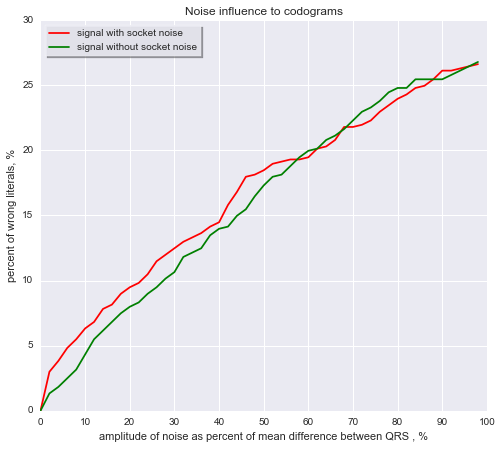

In [351]:
plt.figure(figsize=(8, 7))
plt.plot(np.array(errorsWithSocket[0][0])*100, c='r', label="signal with socket noise")
plt.plot(np.array(errorsWithoutSocket[0][0])*100, c='g', label="signal without socket noise")
xticks_num = 11
plt.xticks(range(0, xticks_num*5, 5), [int(x) for x in np.linspace(0, ampl, xticks_num)/(0.959*errorsWithSocket[0][1])*100])
plt.xlabel("amplitude of noise as percent of mean difference between QRS , %")
#plt.yticks(range(len(errors2)), errors2*100)
plt.ylabel("percent of wrong literals, %")
plt.title("Noise influence to codograms")
plt.legend(loc='upper left', frameon=True, shadow=True, framealpha=0.9)

In [310]:
amplsWith_toFile = []
errorsWith_toFile = []

for e in errorsWithSocket:
    errorsWith_toFile.append(e[0])
    amplsWith_toFile.append(e[1])

amplsWithout_toFile = []
errorsWithout_toFile = []

for e in errorsWithoutSocket:
    errorsWithout_toFile.append(e[0])
    amplsWithout_toFile.append(e[1])

outWith = pd.DataFrame(errorsWith_toFile)
outWithout = pd.DataFrame(errorsWithout_toFile)
outAmpl = pd.DataFrame([amplsWith_toFile, amplsWithout_toFile])

outWith.to_csv("resultsWithSocket.csv")
outWithout.to_csv("resultWithoutSocket.csv")
outAmpl.to_csv("resultAmpls.csv")

           0          1          2          3          4          5  \
0  12.911814  13.780366  19.687188  18.009967  20.227953  38.452956   
1  13.010494  14.564977  19.867290  18.209569  20.731851  35.285605   

           6          7         8          9  
0  25.828619  31.890365  8.943428  12.290698  
1  26.449041  33.242409  8.983410  12.389601  


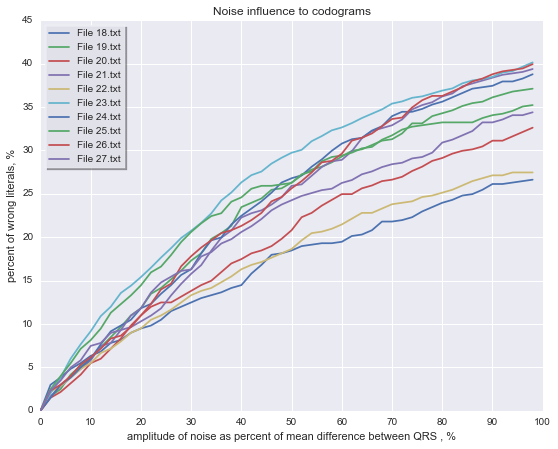

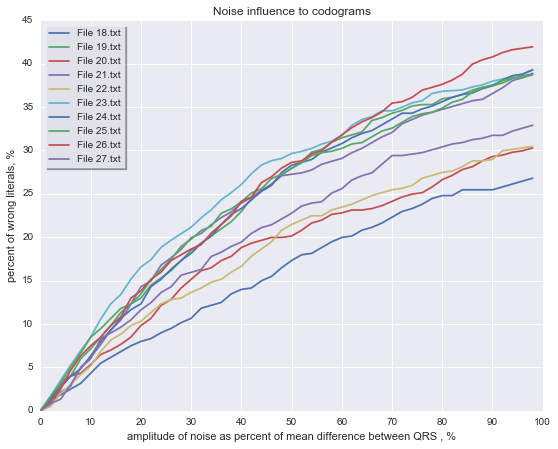

In [358]:
errs1 = []
errs2 = []
for (err1, err2) in zip(errorsWithSocket, errorsWithoutSocket):
    errs1.append(err1[0])
    errs2.append(err2[0])
    
plt.figure(figsize=(9, 7))

for err in zip(errs1, range(len(errs1))):
    plt.plot(np.array(err[0])*100, label = "File " + str(18 + err[1]) + ".txt")
    xticks_num = 11
    plt.xticks(range(0, xticks_num*5, 5), [int(x) for x in np.linspace(0, ampl, xticks_num)/(0.95* errorsWithoutSocket[0][1])*100])
    plt.xlabel("amplitude of noise as percent of mean difference between QRS , %")
    #plt.yticks(range(len(errors2)), errors2*100)
    plt.ylabel("percent of wrong literals, %")
plt.legend(loc='upper left', frameon=True, shadow=True, framealpha=0.9)
plt.title("Noise influence to codograms")
    
plt.figure(figsize=(9, 7))

for err in zip(errs2, range(len(errs2))):
    plt.plot(np.array(err[0])*100, label = "File " + str(18 + err[1]) + ".txt")
    xticks_num = 11
    plt.xticks(range(0, xticks_num*5, 5), [int(x) for x in np.linspace(0, ampl, xticks_num)/(0.95* errorsWithoutSocket[0][1])*100])
    plt.xlabel("amplitude of noise as percent of mean difference between QRS , %")
    #plt.yticks(range(len(errors2)), errors2*100)
    plt.ylabel("percent of wrong literals, %")
    
plt.legend(loc='upper left', frameon=True, shadow=True, framealpha=0.9)
plt.title("Noise influence to codograms")